In [3]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy, ensure_np_array

import cgi_phasec_poppy as cgi
reload(cgi)

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [4]:
!nvidia-smi

Thu Jun 29 13:31:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   36C    P0               75W / 300W|   2959MiB / 81920MiB |     23%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

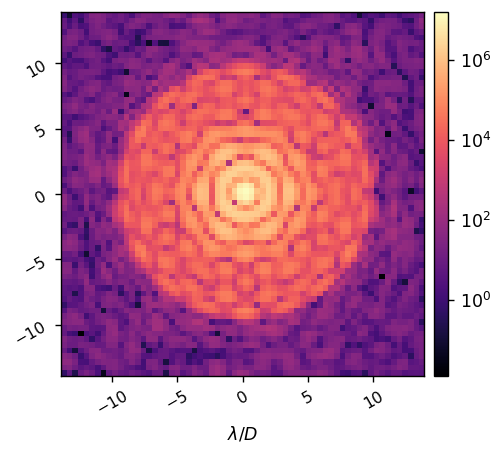

15167884.4713195

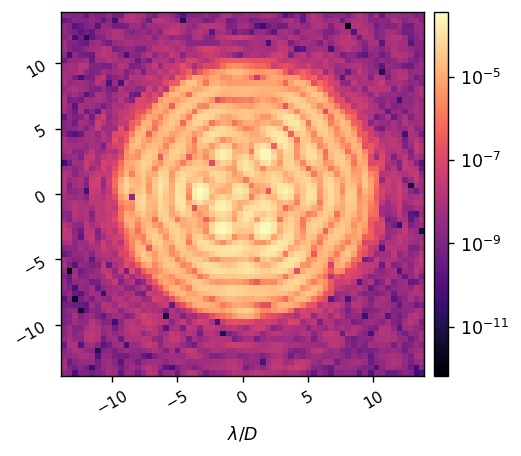

In [5]:
reload(cgi)

source_flux = 2.0208517e8 * u.ph/u.s/u.m**2 # flux of 47 UMa at 575nm with 10% bandpass

c = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=source_flux,
            exp_time=5)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = source_flux/max_ref # divide the source flux to get nominal contrast images
ref_im = c.snap()
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

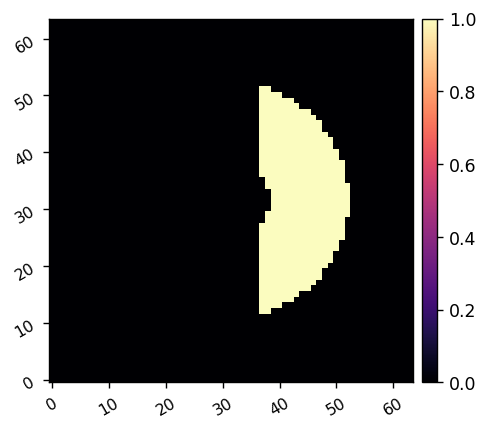

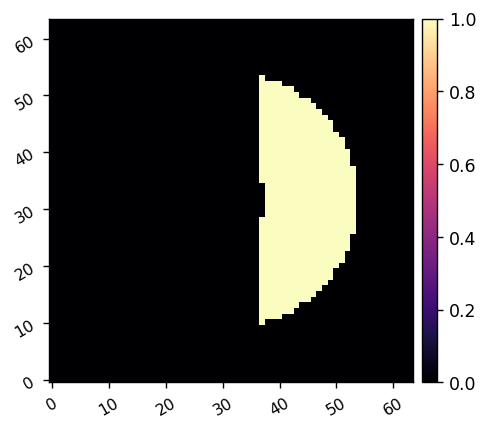

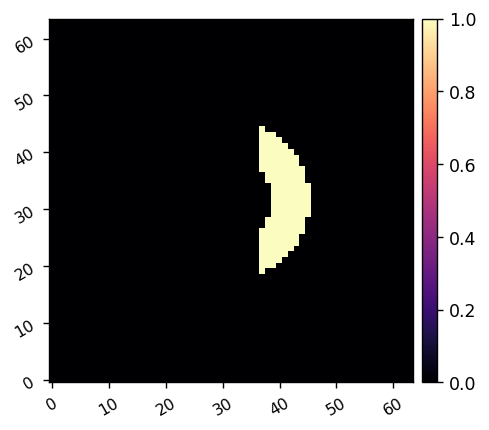

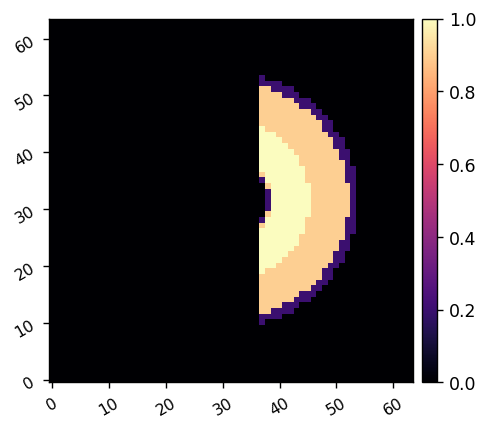

In [62]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

# Create probe and fourier modes

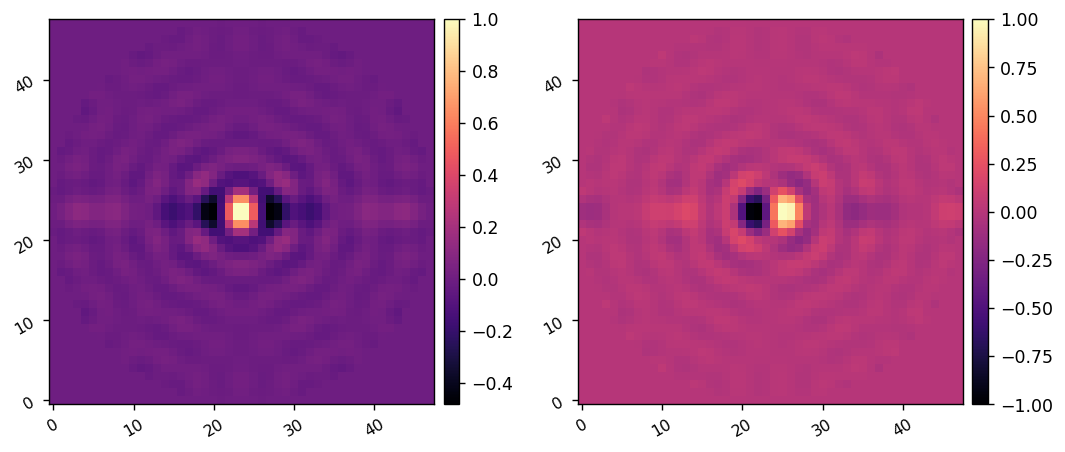

In [7]:
probe_amp = 2.5e-8
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=1) 
probe_modes = wfsc.utils.create_fourier_probes(fourier_modes, plot=True)

In [8]:
Nacts = int(c.dm_mask.sum())

calib_amp = 2.5e-9

calib_modes = xp.zeros((Nacts, c.Nact, c.Nact))
count=0
for i in range(c.Nact):
    for j in range(c.Nact):
        if c.dm_mask[i,j]:
            calib_modes[count, i,j] = 1
            count+=1
            
calib_modes = calib_modes[:,:].reshape(Nacts, c.Nact**2)

# import time
# for i in range(Nacts):
#     try:
#         wfsc.imshow1(calib_modes[i].reshape(Nact,Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

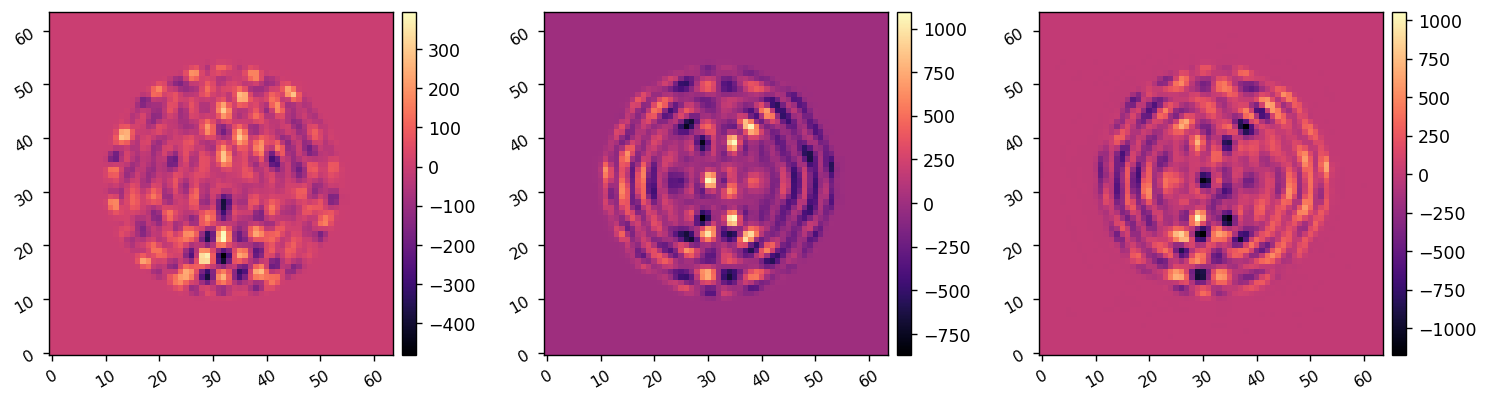

In [9]:
reload(wfsc.iefc)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [10]:
reload(wfsc.iefc_2dm)

response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, ensure_np_array(calib_modes), 
                                                         return_all=True)


Calibrating iEFC...


KeyboardInterrupt: 

In [59]:
date = 20230629
response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlc_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlc_iefc_2dm_poke_response_cube_{date}.fits'))

In [17]:
response_cube.shape

(3560, 2, 4096)

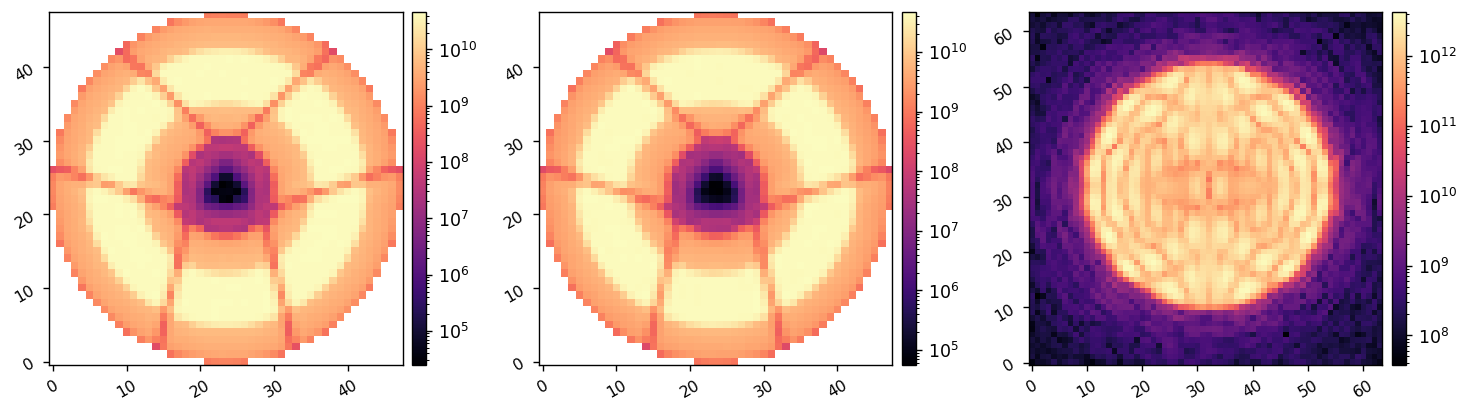

In [60]:
reload(wfsc.utils)
dm1_response_sum = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[::2], c.dm_mask)
dm2_response_sum = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[1::2], c.dm_mask)
fp_response_sum = xp.sum(abs(response_cube), axis=(0,1)).reshape(npsf, npsf)

wfsc.imshow3(dm1_response_sum , dm2_response_sum, fp_response_sum, lognorm=True)

# Run IEFC

In [28]:
len(probe_modes)

2

Running I-EFC...
	Closed-loop iteration 1 / 10


(3560,)

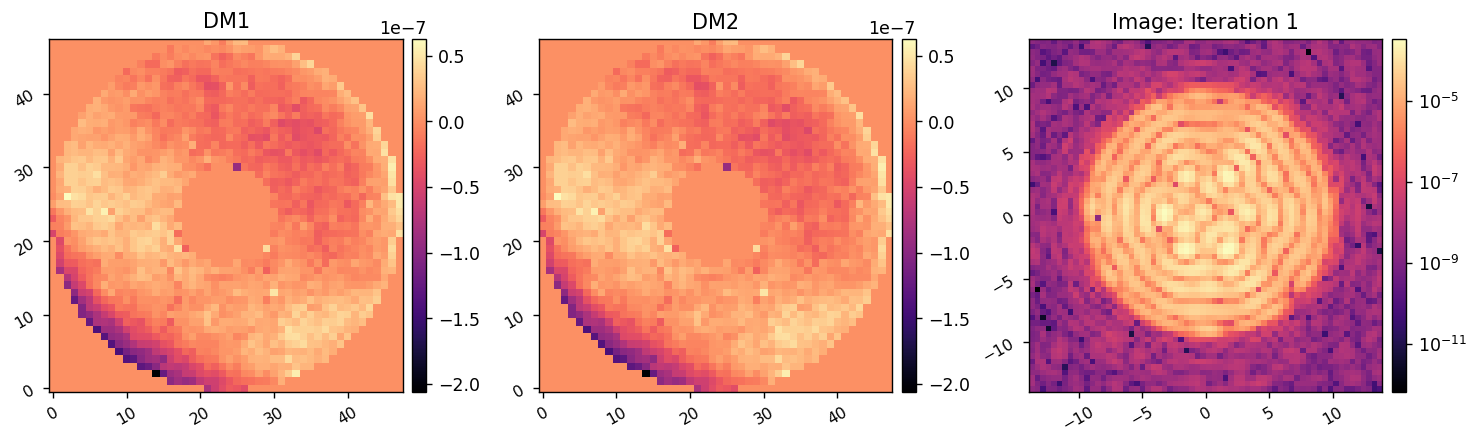

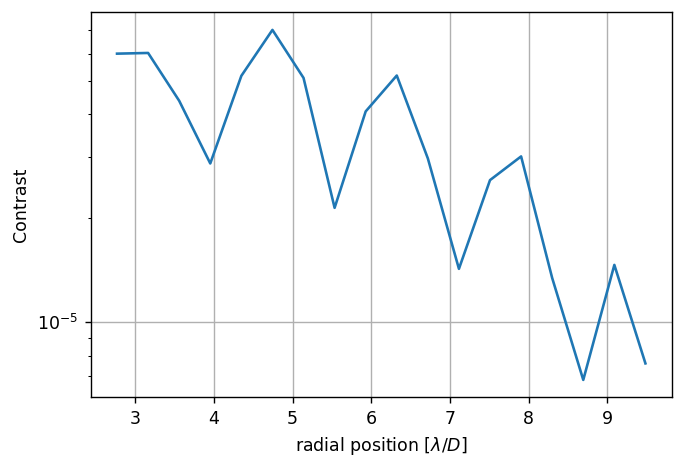

	Closed-loop iteration 2 / 10


(3560,)

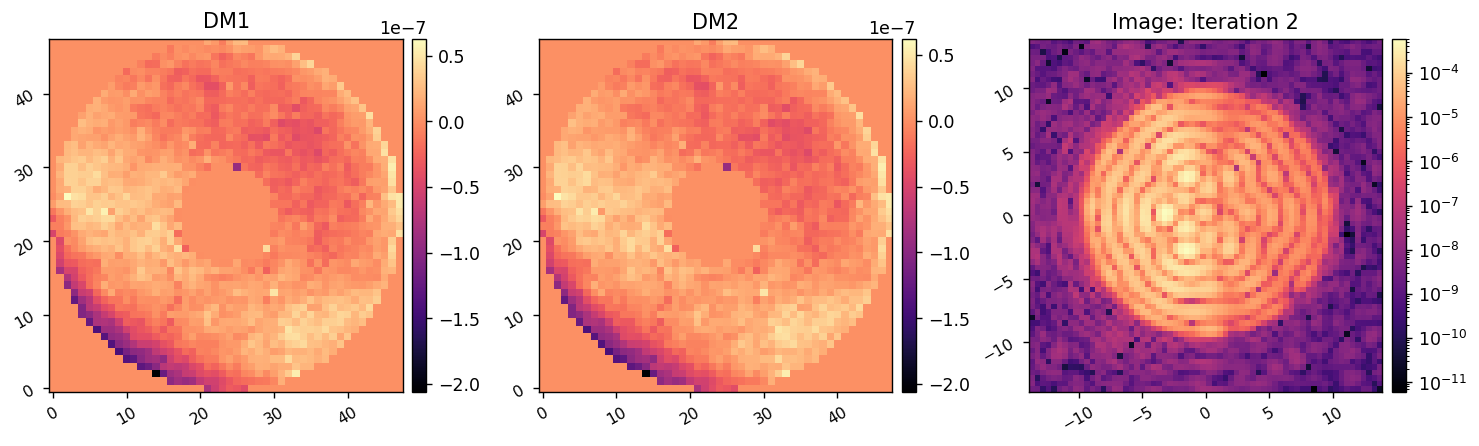

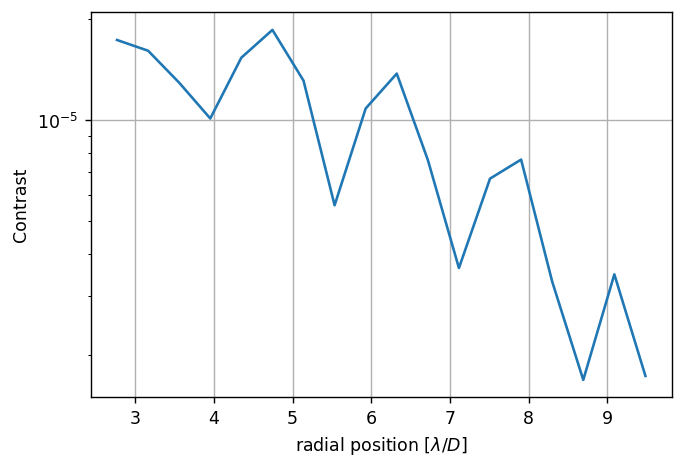

	Closed-loop iteration 3 / 10


(3560,)

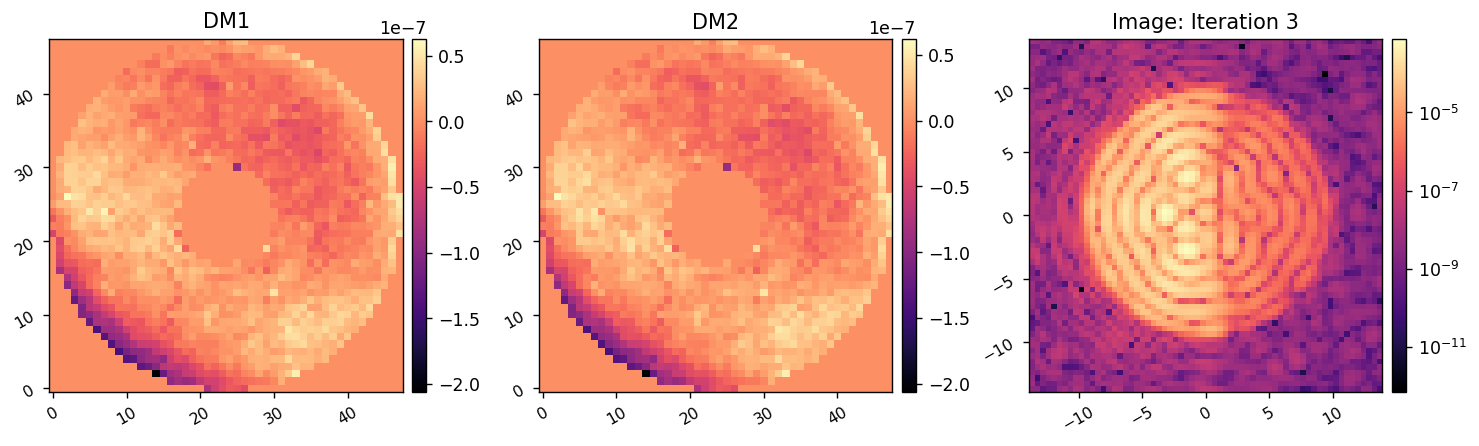

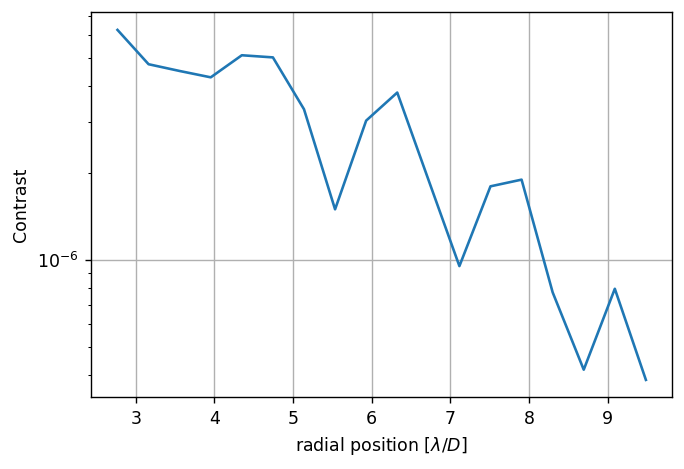

	Closed-loop iteration 4 / 10


(3560,)

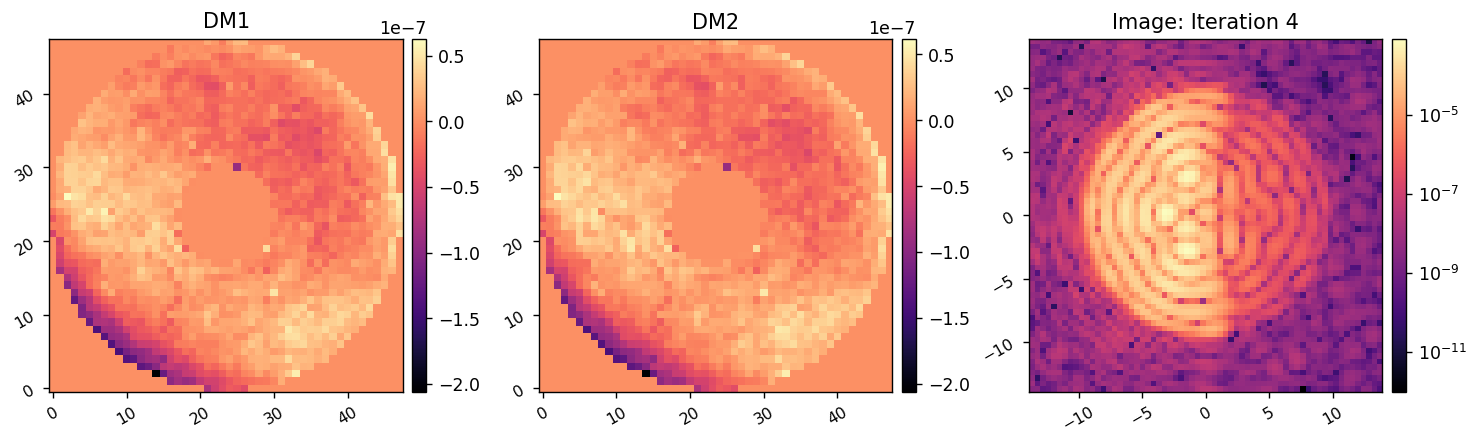

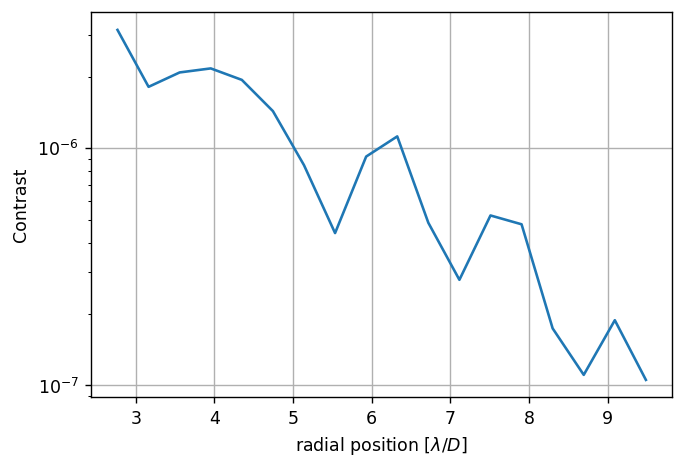

	Closed-loop iteration 5 / 10


(3560,)

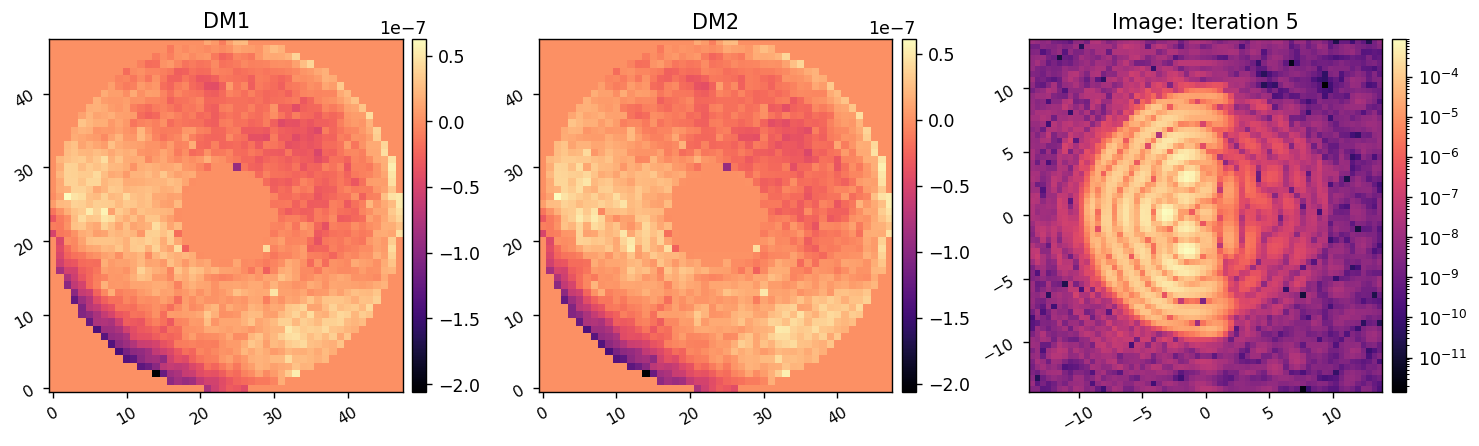

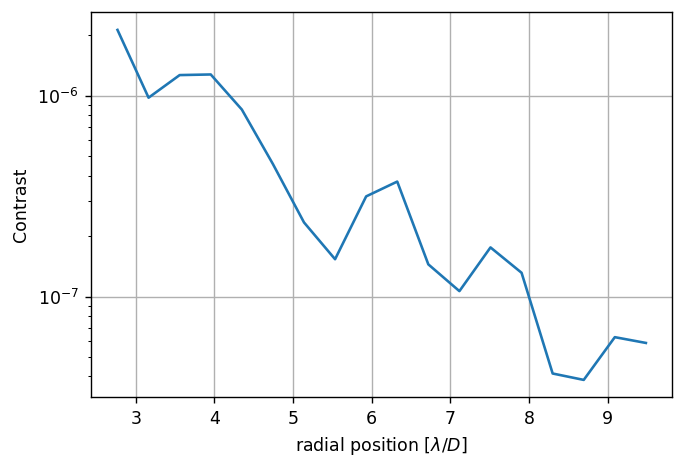

	Closed-loop iteration 6 / 10


(3560,)

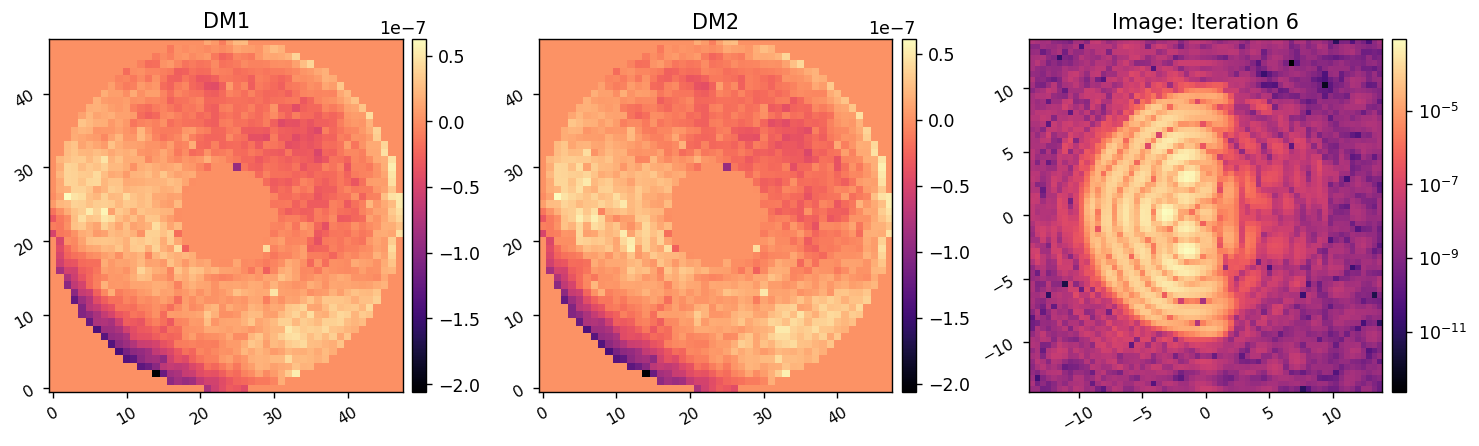

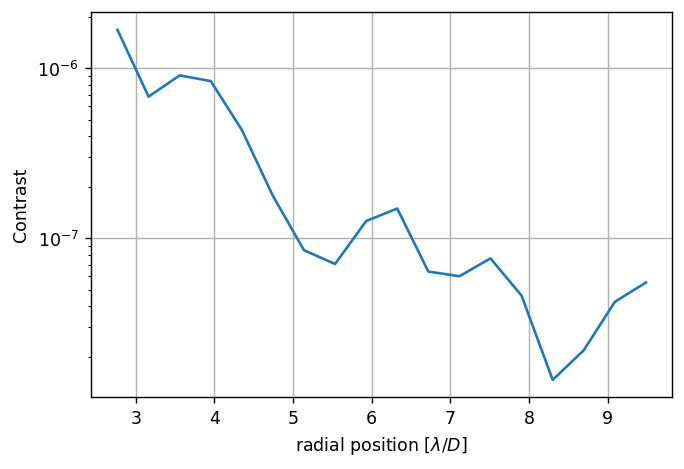

	Closed-loop iteration 7 / 10


(3560,)

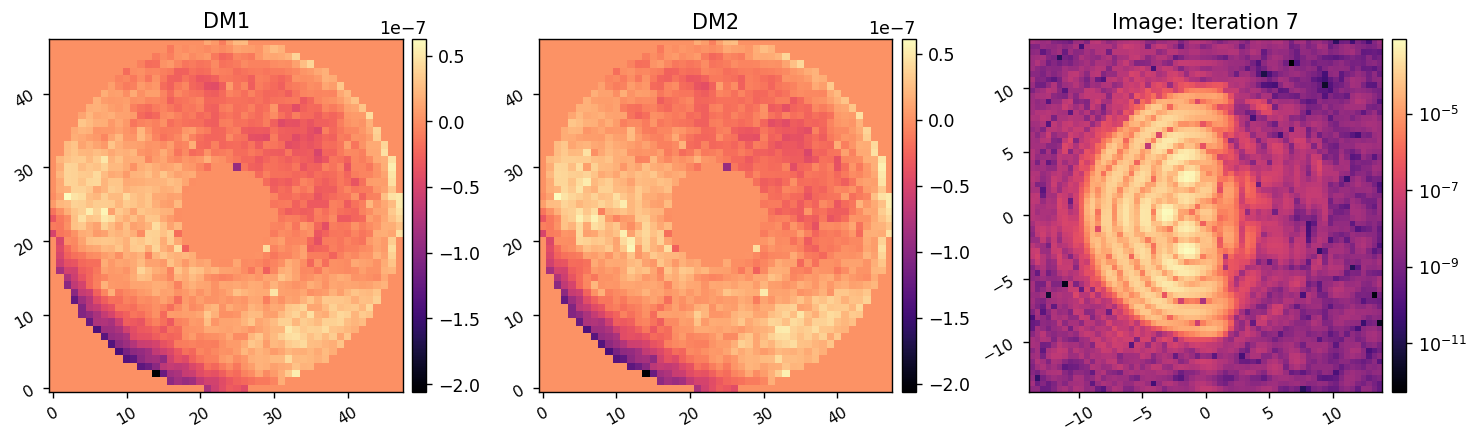

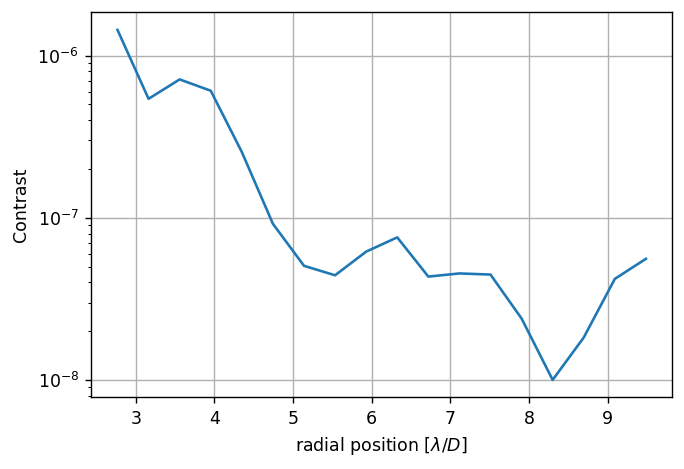

	Closed-loop iteration 8 / 10


(3560,)

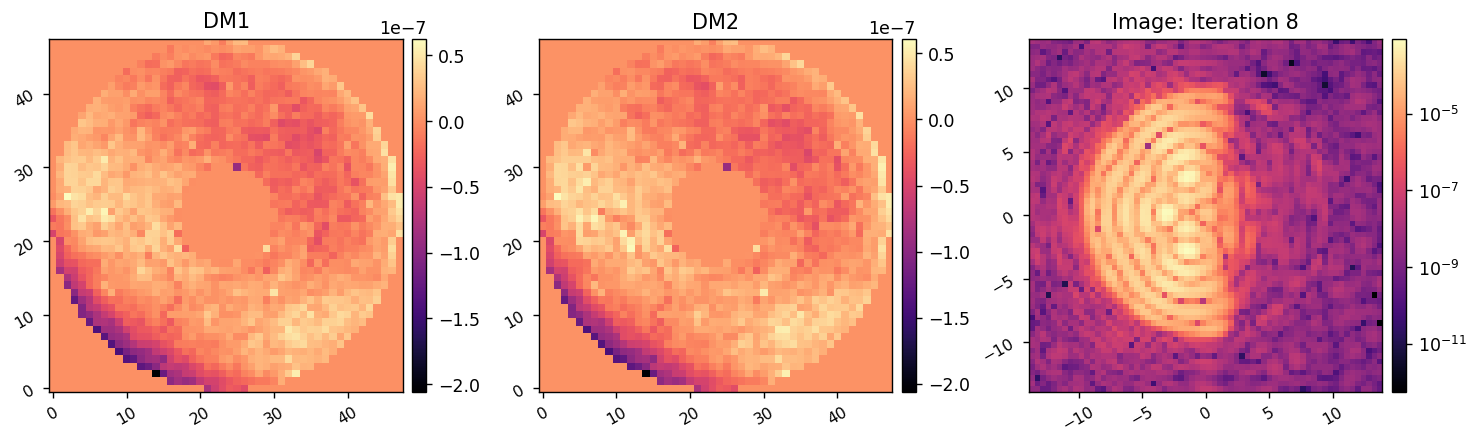

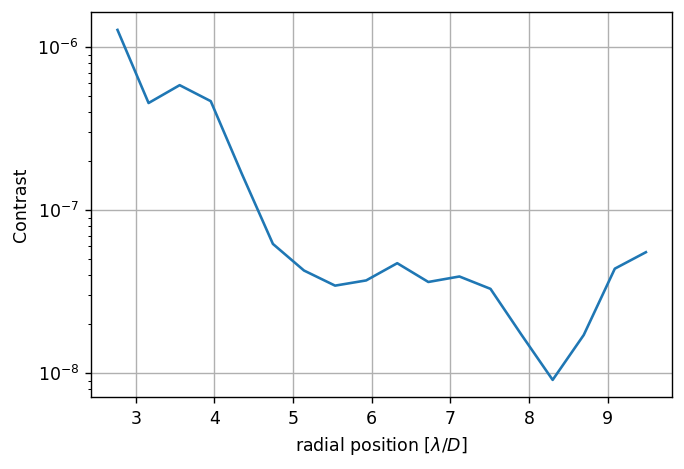

	Closed-loop iteration 9 / 10


(3560,)

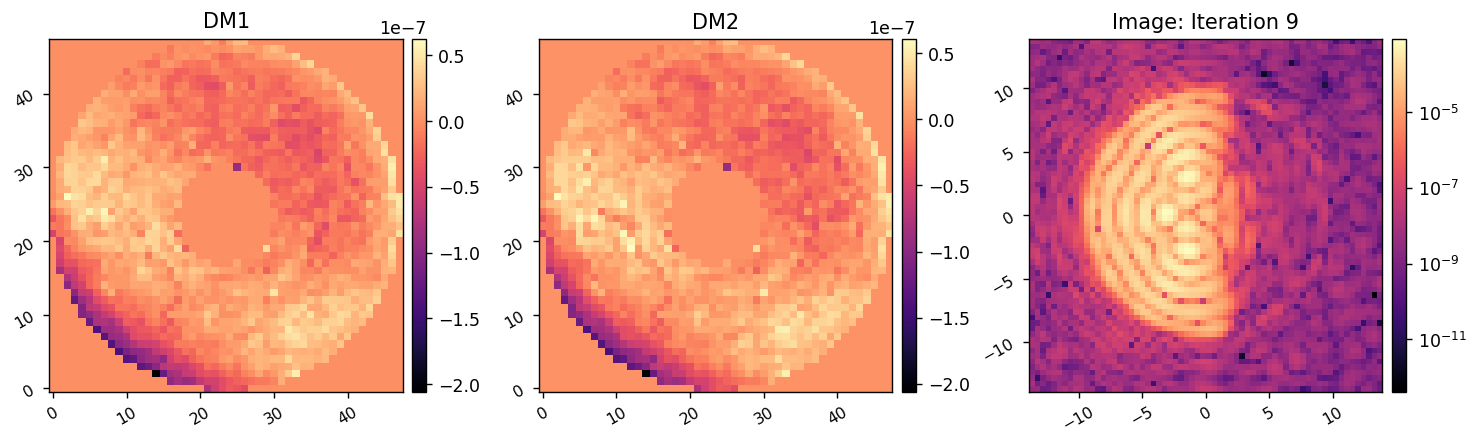

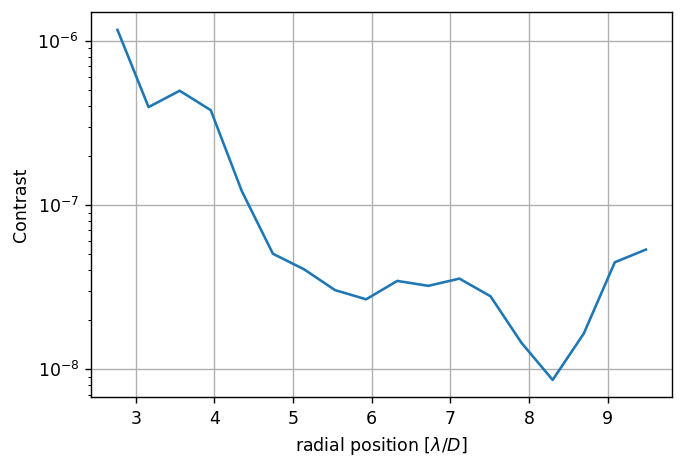

	Closed-loop iteration 10 / 10


(3560,)

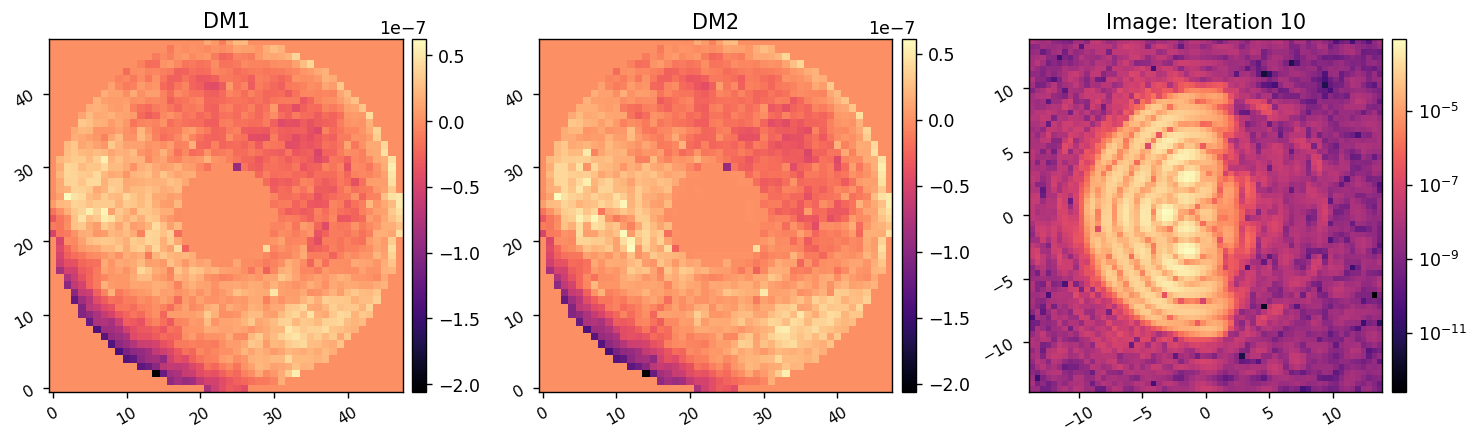

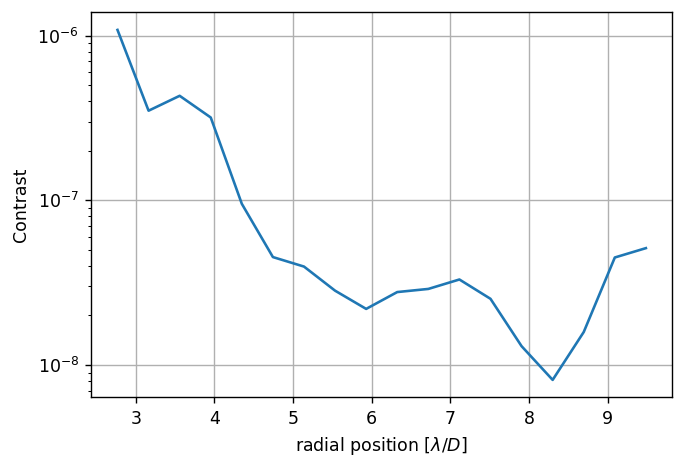

I-EFC loop completed in 22.364s.


In [63]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

Running I-EFC...
	Closed-loop iteration 1 / 10


(3560,)

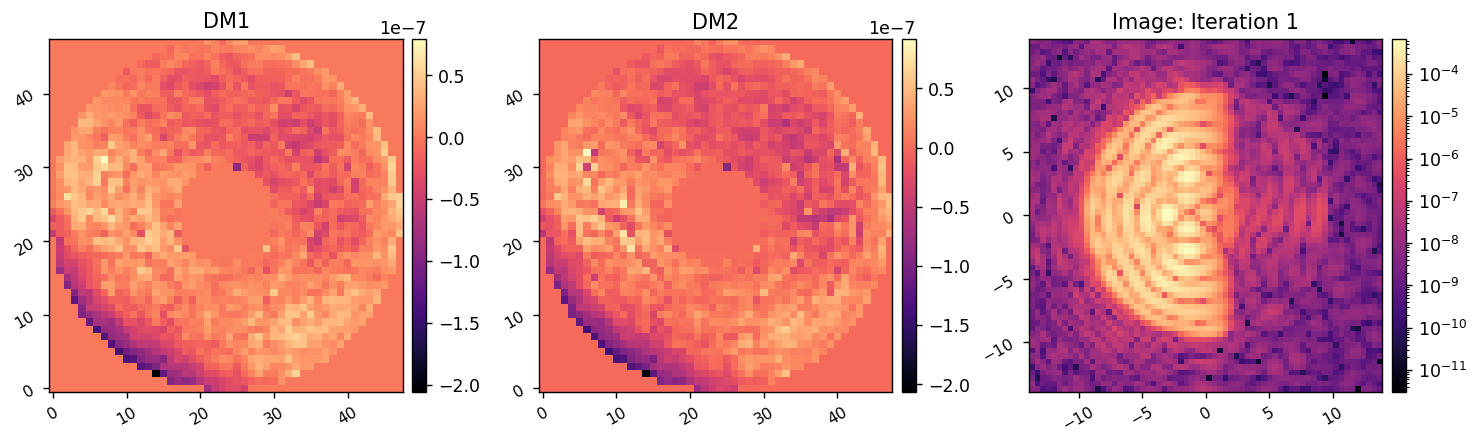

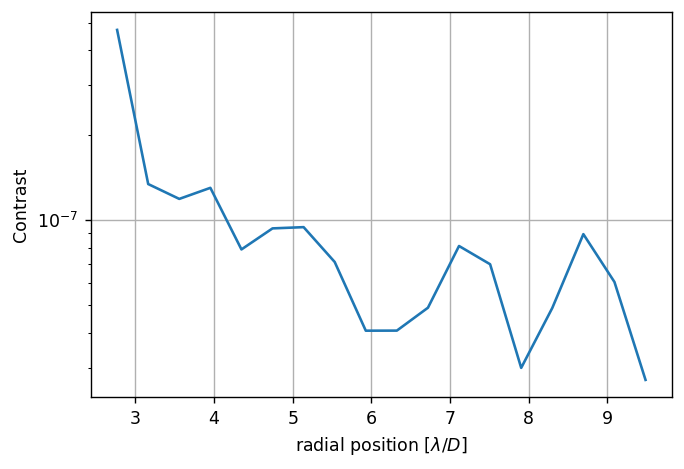

	Closed-loop iteration 2 / 10


(3560,)

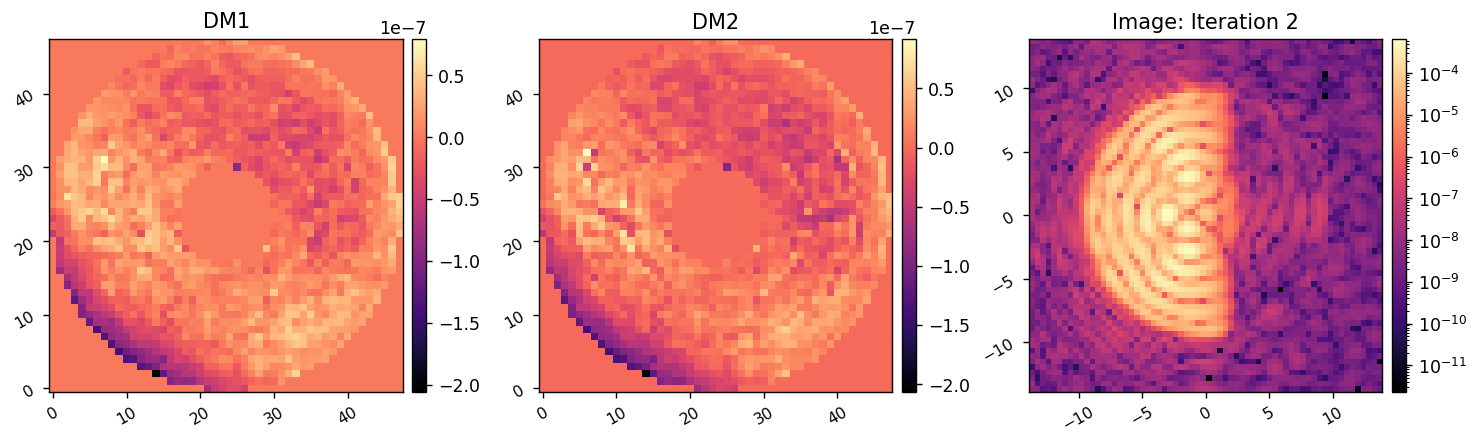

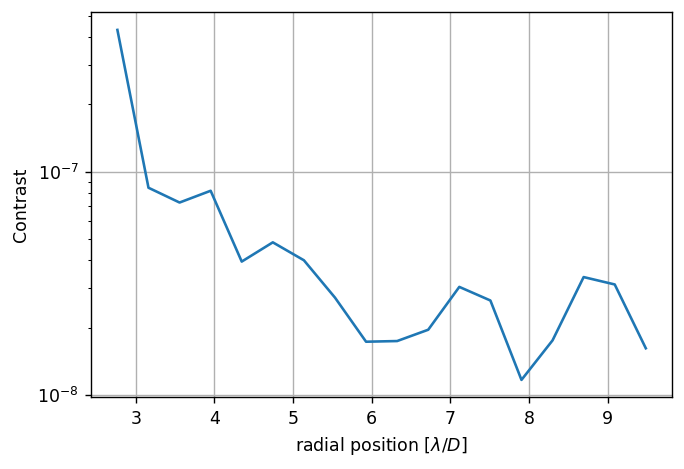

	Closed-loop iteration 3 / 10


(3560,)

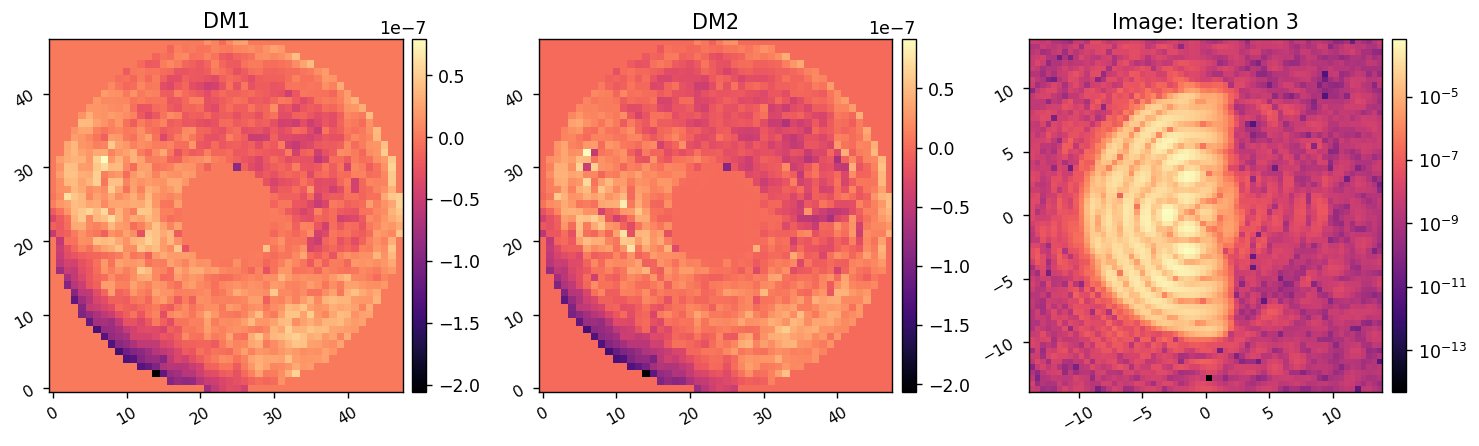

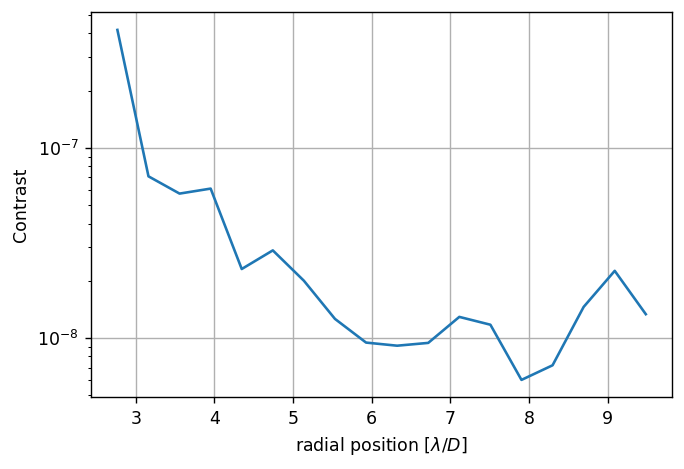

	Closed-loop iteration 4 / 10


(3560,)

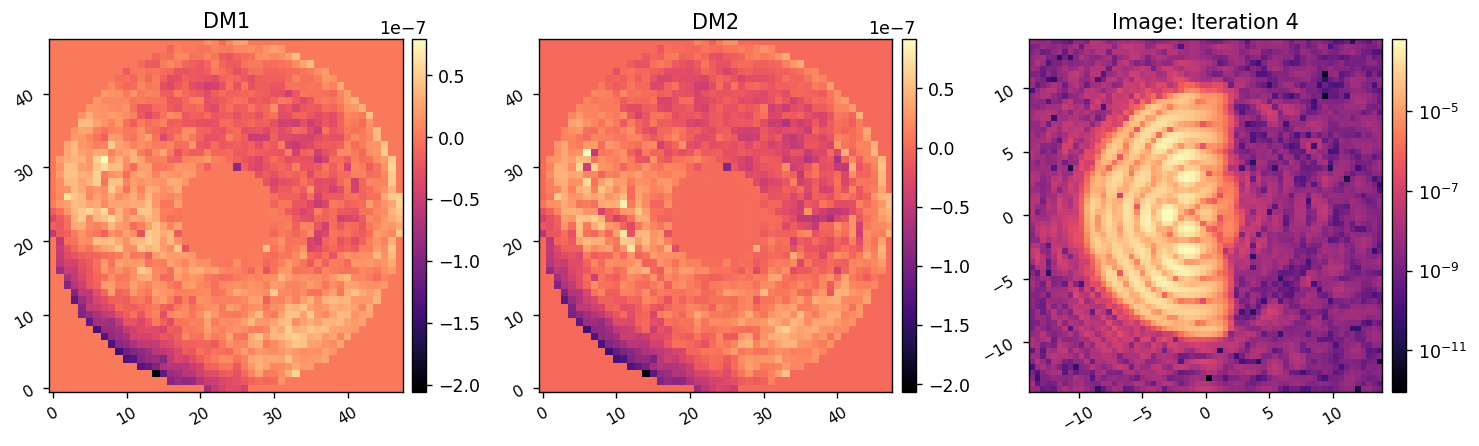

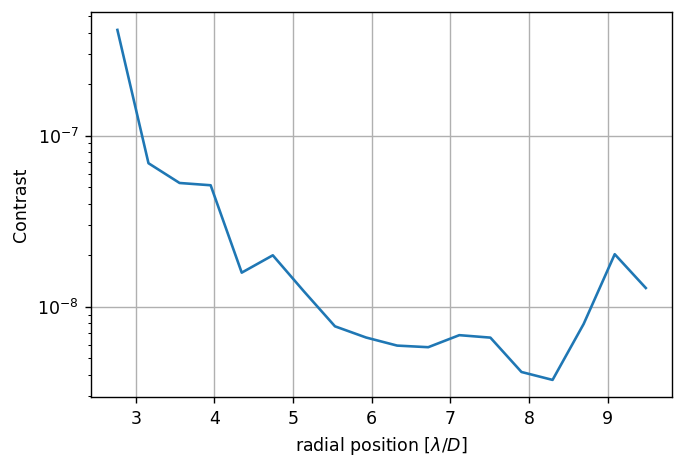

	Closed-loop iteration 5 / 10


(3560,)

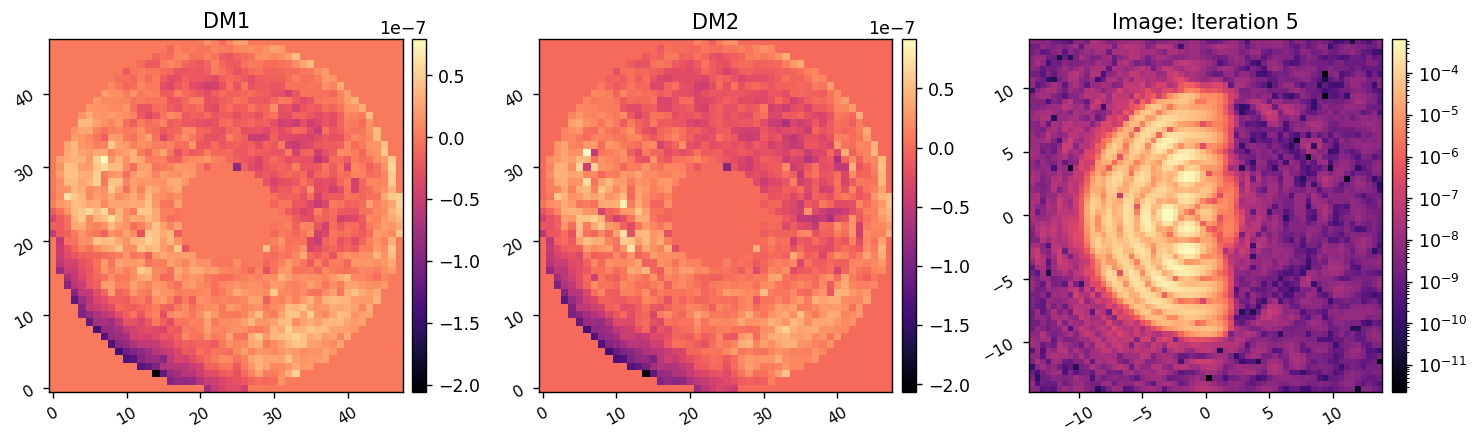

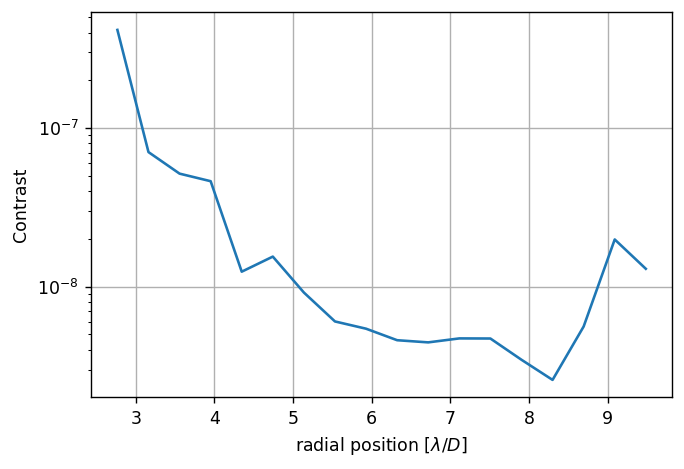

	Closed-loop iteration 6 / 10


(3560,)

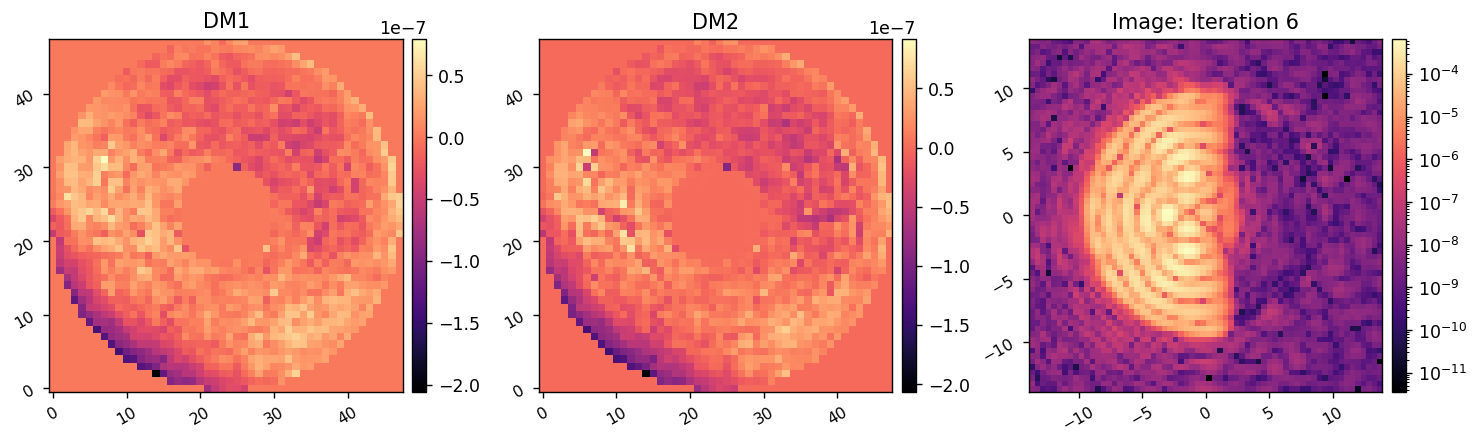

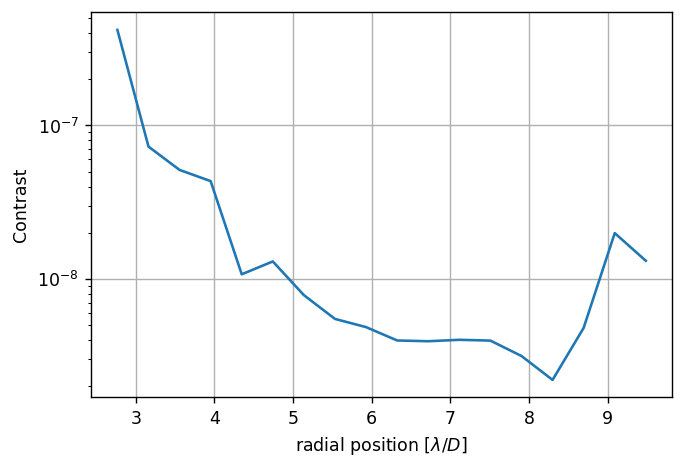

	Closed-loop iteration 7 / 10


(3560,)

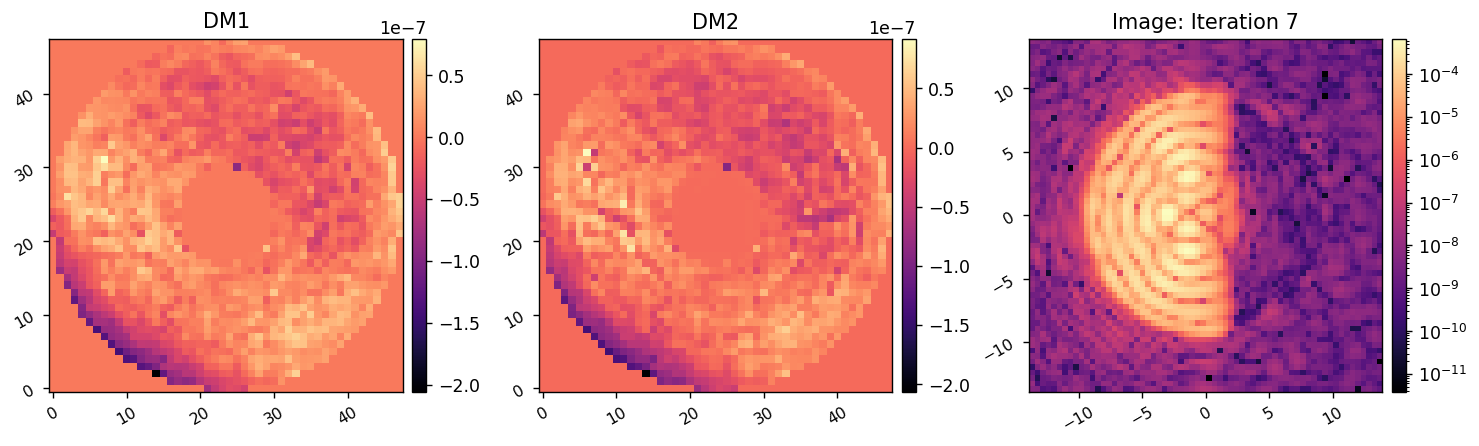

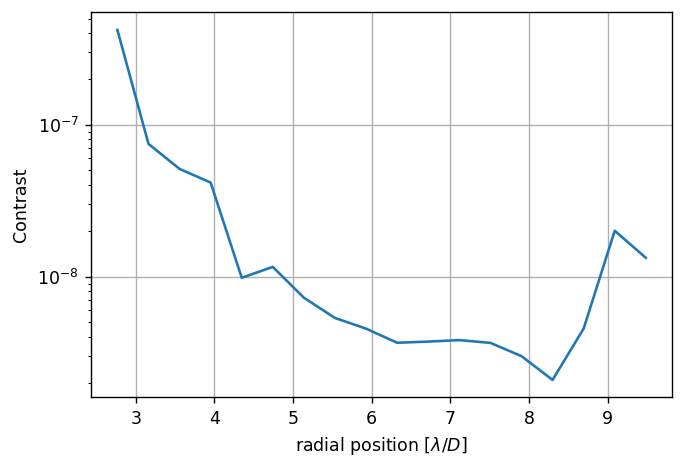

	Closed-loop iteration 8 / 10


(3560,)

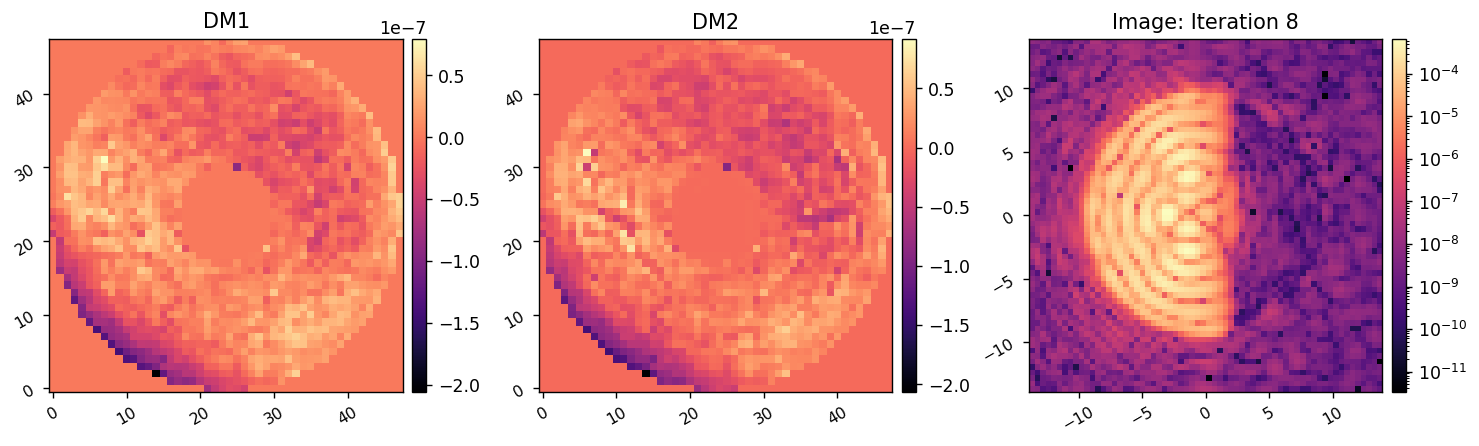

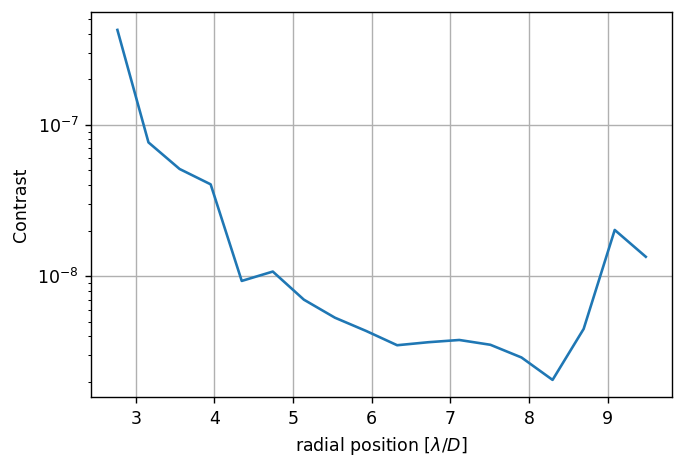

	Closed-loop iteration 9 / 10


(3560,)

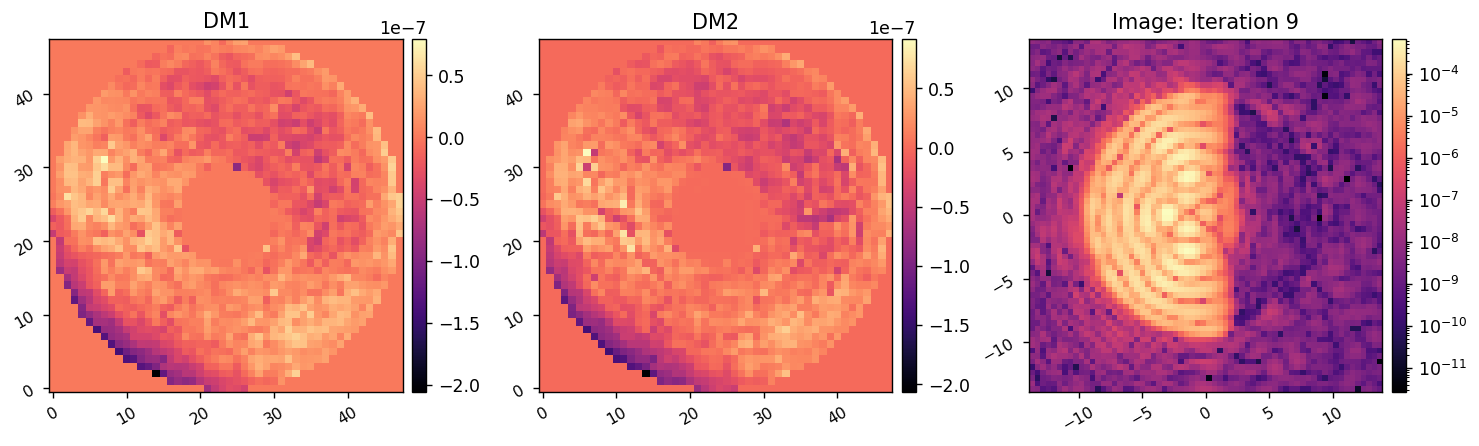

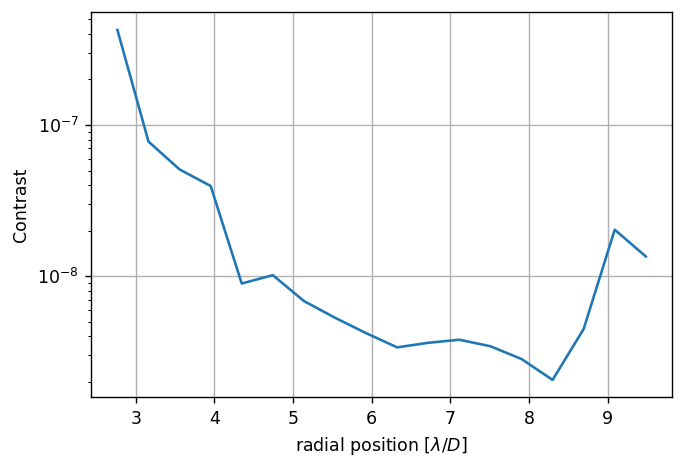

	Closed-loop iteration 10 / 10


(3560,)

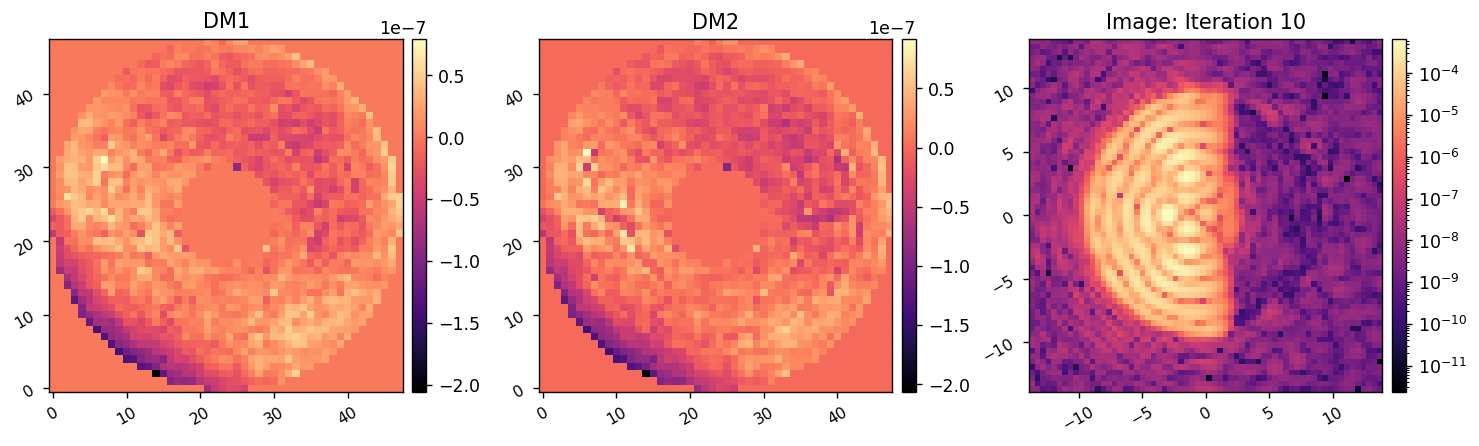

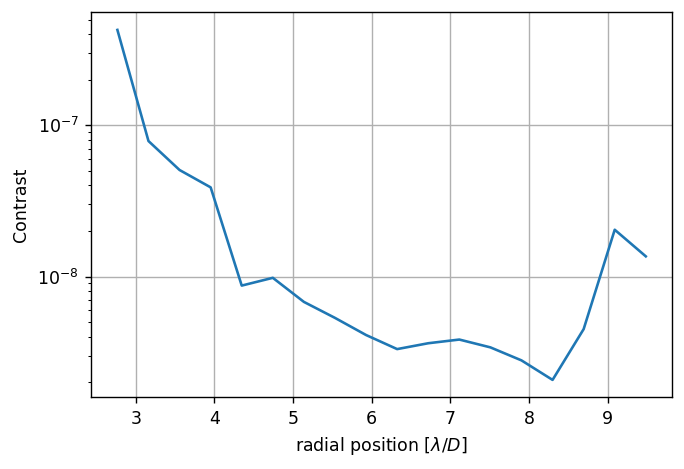

I-EFC loop completed in 24.113s.


In [67]:
reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

Running I-EFC...
	Closed-loop iteration 1 / 5


(3560,)

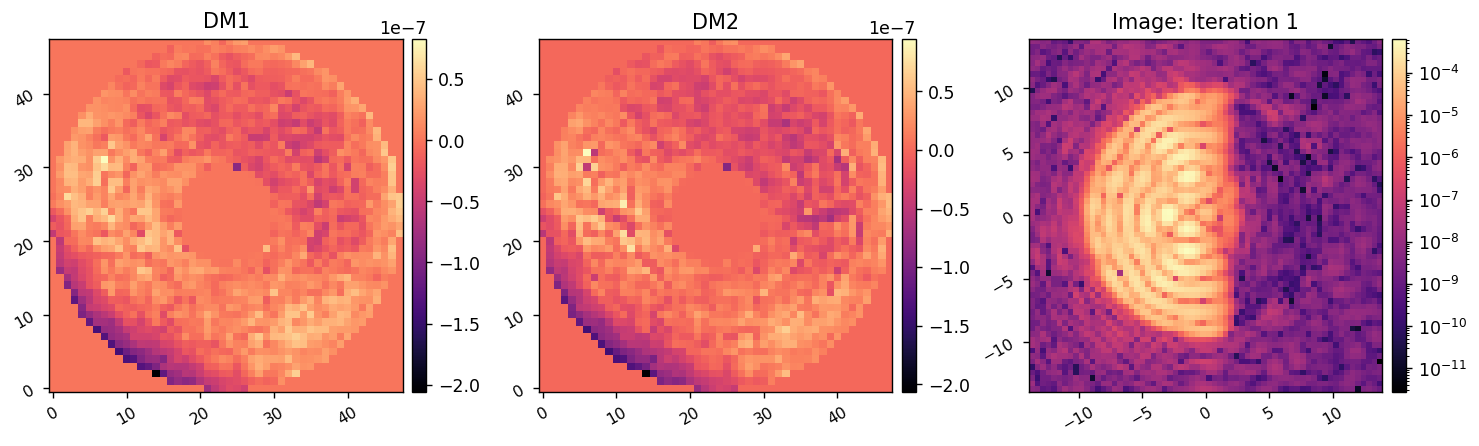

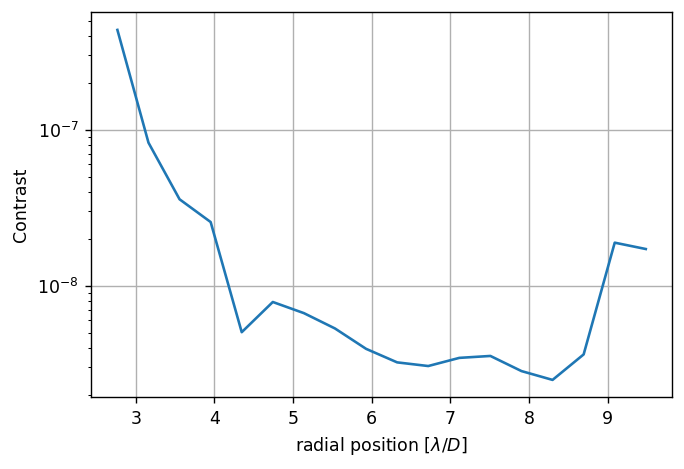

	Closed-loop iteration 2 / 5


(3560,)

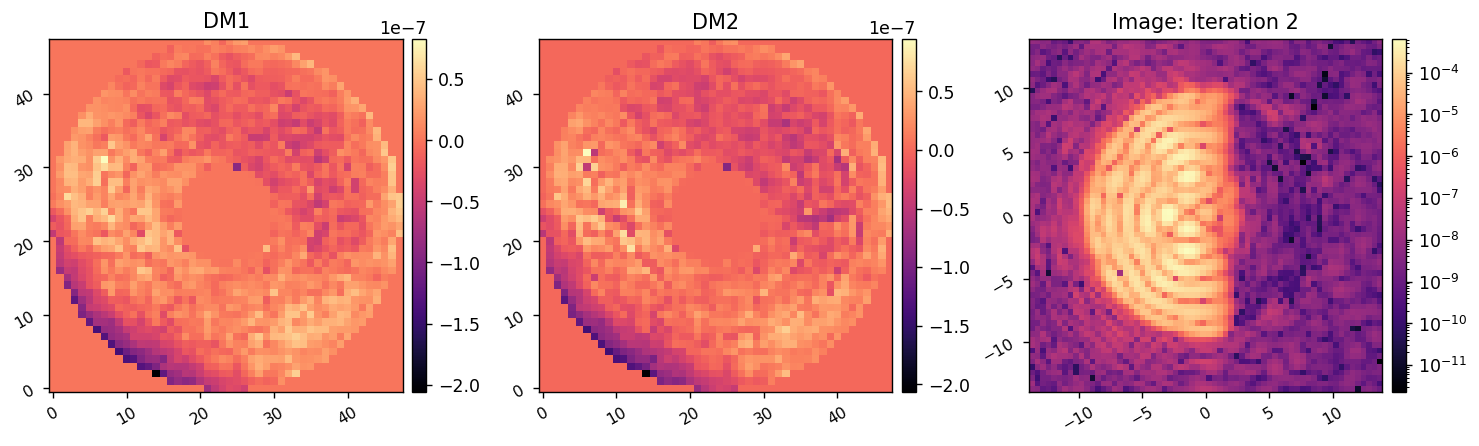

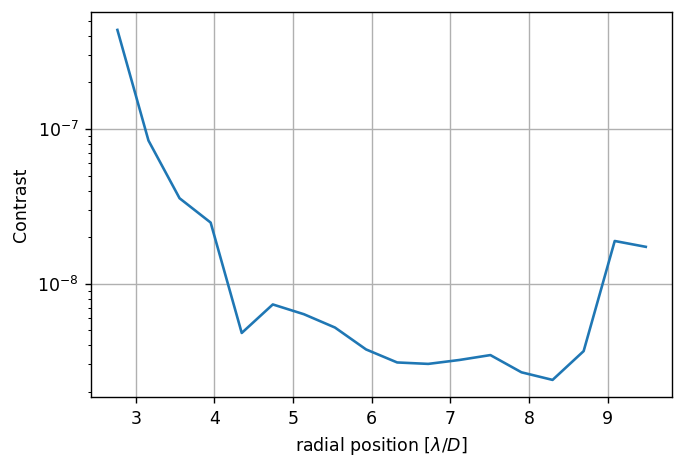

	Closed-loop iteration 3 / 5


(3560,)

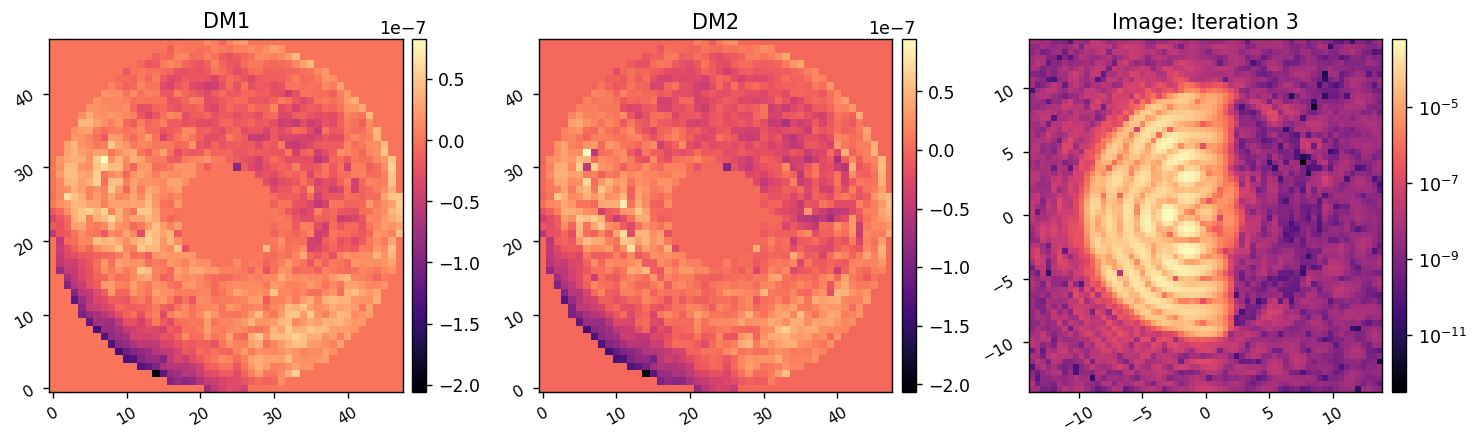

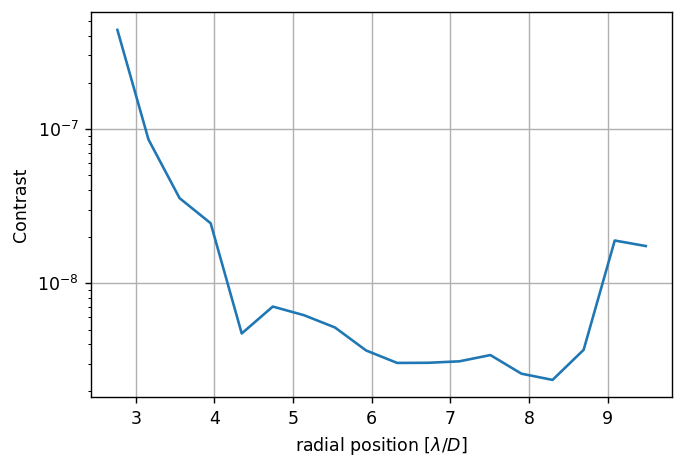

	Closed-loop iteration 4 / 5


(3560,)

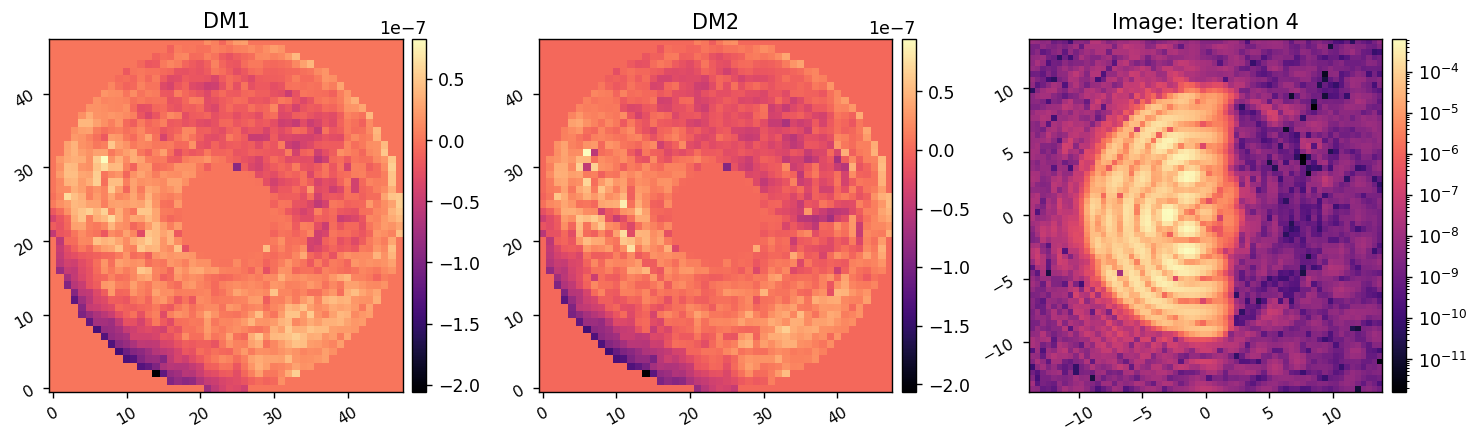

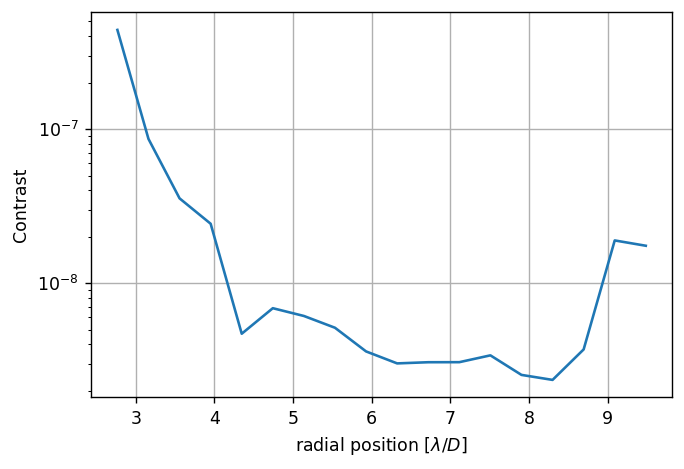

	Closed-loop iteration 5 / 5


(3560,)

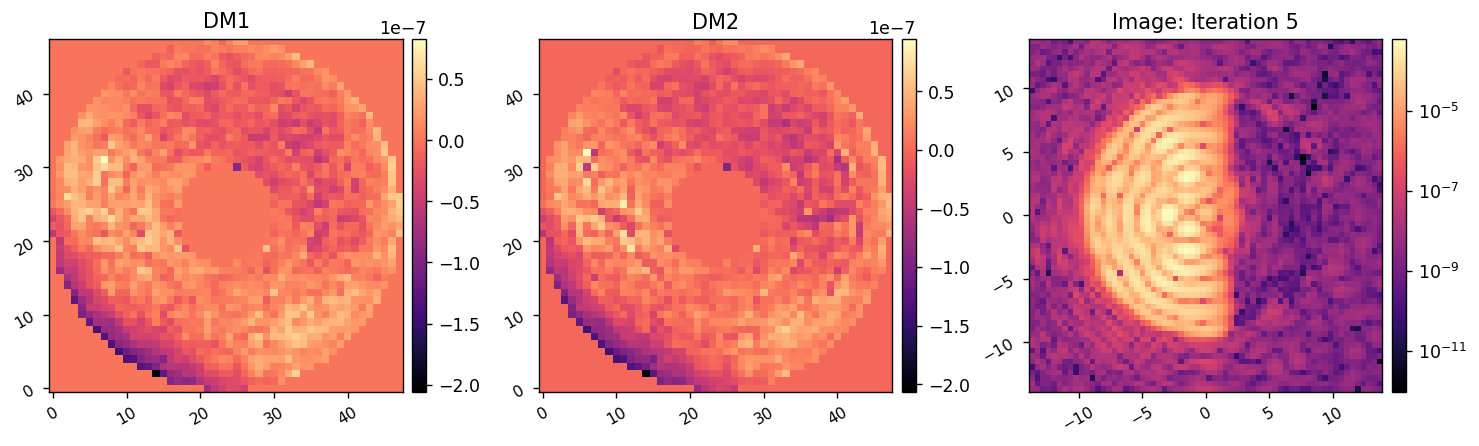

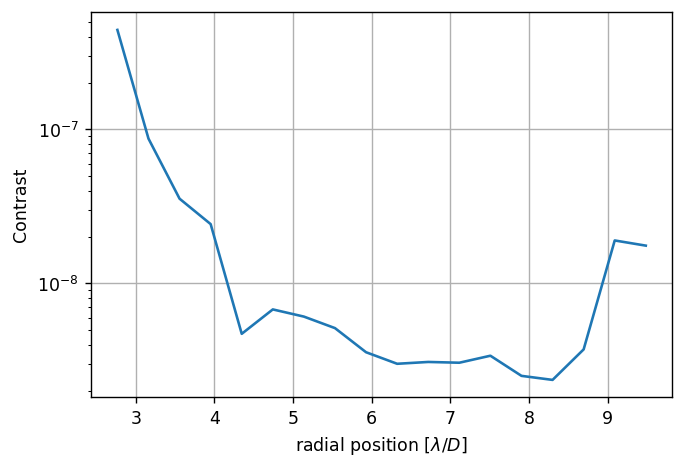

I-EFC loop completed in 11.999s.


In [71]:
reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )